In [14]:
import ROOT

# Open ROOT files
f_bg = ROOT.TFile.Open("histograms_background.root")
f_sig = ROOT.TFile.Open("histograms_m1000.root")

# Get histograms (replace 'hist_name' with the actual histogram name)
h_bg = f_bg.Get("jet_mass_background")
h_sig = f_sig.Get("jet_mass_1000")

h_bg.GetXaxis().SetRangeUser(0, 1500)  # for example
h_sig.GetXaxis().SetRangeUser(0, 1500)




# Set styles for distinction
h_bg.SetLineColor(ROOT.kRed)
h_bg.SetLineWidth(2)
h_bg.SetTitle("Background vs Signal;X-axis title;Entries")

h_sig.SetLineColor(ROOT.kBlue)
h_sig.SetLineWidth(2)

# Normalize if needed (optional)
# h_bg.Scale(1.0 / h_bg.Integral())
# h_sig.Scale(1.0 / h_sig.Integral())

# Create canvas and draw
c = ROOT.TCanvas("c", "Overlay", 800, 600)
h_bg.Draw("HIST")
h_sig.Draw("HIST SAME")

# Add legend
legend = ROOT.TLegend(0.7, 0.7, 0.9, 0.85)
legend.AddEntry(h_bg, "Background", "l")
legend.AddEntry(h_sig, "Signal (m1000)", "l")
legend.Draw()

c.Update()
c.Draw()
c.SaveAs("1TeV_and_Background.png")


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file 1TeV_and_Background.png has been created


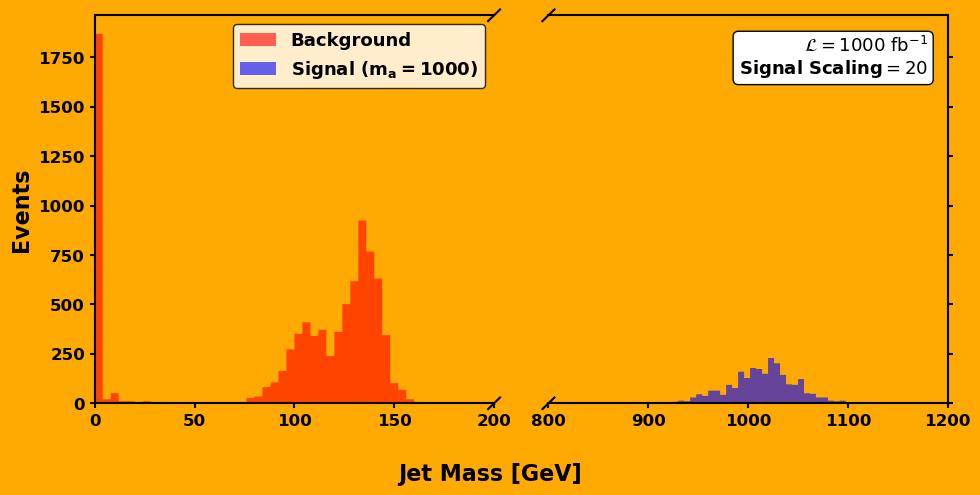

In [67]:
import uproot
import numpy as np
import matplotlib.pyplot as plt

def rebin(values, edges, factor):
    assert len(values) % factor == 0, "Number of bins must be divisible by rebin factor"
    values_rebinned = values.reshape(-1, factor).sum(axis=1)
    edges_rebinned = edges[::factor]
    if len(edges_rebinned) == len(values_rebinned):
        edges_rebinned = np.append(edges_rebinned, edges[-1])
    return values_rebinned, edges_rebinned

# Cross-sections (in fb) for the three masses and background
sigma_1000 = 0.133198
sigma_2000 = 0.25754
sigma_background = 3.4107

# Luminosity (in fb⁻¹)
luminosity = 1000
n_events = 1000
scaling = 20

# Scaling factors
scaling_factors = {
    "1000": scaling * sigma_1000 * luminosity / n_events,
    "2000": scaling * sigma_2000 * luminosity / n_events,
    "background": sigma_background * luminosity / n_events
}

# Open ROOT files and load histograms
f_bg = uproot.open("histograms_background.root")
f_sig = uproot.open("histograms_m1000.root")
h_bg = f_bg["jet_mass_background"]
h_sig = f_sig["jet_mass_1000"]

bg_values, bg_edges = h_bg.to_numpy()
sig_values, sig_edges = h_sig.to_numpy()

# Apply scaling factors
bg_values *= scaling_factors["background"]
sig_values *= scaling_factors["1000"]

# Rebin
bg_values, bg_edges = rebin(bg_values, bg_edges, factor=20)
sig_values, sig_edges = rebin(sig_values, sig_edges, factor=30)

# Set up plot style
plt.rcParams.update({
    "font.size": 13,
    "font.weight": "bold",
    "axes.labelweight": "bold",
    "xtick.major.width": 1.5,
    "ytick.major.width": 1.5,
    "axes.linewidth": 1.5,
    "legend.frameon": True
})

# Setup canvas and pads
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 5), gridspec_kw={'width_ratios': [1, 1]})
fig.patch.set_facecolor((250/250, 167/250, 2/250))
ax1.set_facecolor((250/250, 167/250, 2/250))
ax2.set_facecolor((250/250, 167/250, 2/250))

range1 = (0, 200)
range2 = (800, 1200)

# Left panel
ax1.hist(bg_edges[:-1], bins=bg_edges, weights=bg_values,
         histtype='stepfilled', alpha=0.6, color='red', label='Background')
ax1.hist(sig_edges[:-1], bins=sig_edges, weights=sig_values,
         histtype='stepfilled', alpha=0.6, color='blue', label=r'Signal ($\mathbf{m_a = 1000}$)')
ax1.set_xlim(*range1)
fig.supxlabel(r"Jet Mass [GeV]", fontsize=16, fontweight = "bold")
ax1.set_ylabel(r"Events", fontsize=16)
ax1.legend(fontsize=13, edgecolor='black')

# Right panel
ax2.hist(bg_edges[:-1], bins=bg_edges, weights=bg_values,
         histtype='stepfilled', alpha=0.6, color='red')
ax2.hist(sig_edges[:-1], bins=sig_edges, weights=sig_values,
         histtype='stepfilled', alpha=0.6, color='blue')
ax2.set_xlim(*range2)

# Axis tweaks
ax1.tick_params(axis='both', which='major', labelsize=12, width=1.5)
ax2.tick_params(axis='both', which='major', labelsize=12, width=1.5)

# Broken axis
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax2.yaxis.tick_right()

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d), (1-d,1+d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d,+d), (-d,+d), **kwargs)
ax2.plot((-d,+d), (1-d,1+d), **kwargs)

# LaTeX-style annotation
ax2.text(0.95, 0.95,
         r"$\mathbf{\mathcal{L}} = 1000~\mathrm{fb}^{-1}$" + "\n" +
         r"$\mathbf{Signal~Scaling} = 20$",
         transform=ax2.transAxes,
         fontsize=13,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle="round,pad=0.3", facecolor='white', edgecolor='black'))

plt.tight_layout()
plt.show()
